# Results for paper: TITLE

In [36]:
from openfermion import get_sparse_operator
from scipy.sparse.linalg import eigsh
from pathlib import Path
from nbed.utils import save_ordered_xyz_file, pubchem_mol_geometry

def ground(hamiltonian):
    sparse_ham = get_sparse_operator(hamiltonian)
    eigenvalue, _ = eigsh(sparse_ham, k=1, which='SA')
    return eigenvalue[0]

def find_and_save(mol_name):
    if Path(f'./molecular_structures/{mol_name}.xyz').exists():
        print(f'xyz file for {mol_name} already exists.\n')
        return

    geo_dict = pubchem_mol_geometry(mol_name)
    print('Molecule geometry:')
    print(geo_dict)
    save_ordered_xyz_file(mol_name, geo_dict, [0])
    print(f'xyz file for {mol_name} created.\n')

def print_results(result, active):
    
    print(f"Qubits\t\t{result[active]['mu']['n_qubits']}/{result[active]['huz']['n_qubits']}/{result['full']['n_qubits']}")
    print(f"Terms\t\t{result[active]['mu']['terms']}/{result[active]['huz']['terms']}/{result['full']['terms']}")
    print(f'DFT:\t\t{result["e_dft"]}')
    #print(f"CCSD Emb:\t{result['mu']['e_ccsd']}/{result['huz']['e_ccsd']}")
    print(f"Mu Emb:\t\t{result[active]['mu']['ground']}")
    print(f"Huz Emb:\t{result[active]['huz']['ground']}")
    print(f"Diagonalized:\t{result['full']['ground']}")
    print("\n")

def save_data(result, mol_name, localisation, force: bool):
    savefile = f'../data/{mol_name}_{localisation}.json'

    with open(savefile, 'w') as f:
        json.dump(result, f, indent=4)
        print(f'{savefile} created.')

In [36]:
find_and_save('pyridine')

xyz file for pyridine already exists.



In [71]:
from pathlib import Path
from pyscf.gto import Mole
import nbed
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from nbed.ham_converter import HamiltonianConverter
from openfermion import count_qubits
import json
from pyscf import cc

localisation = ['spade','mullikan','boys','ipo']

# Need to build paths to xyz files.
max_atoms = 3

def get_results(mol_name, n_active_atoms, localisation='pipek-mezey', qubits=None, force=True):
    savefile = f'../data/{mol_name}_{localisation}.json'
    if Path(savefile).exists() and not force:
        in_string = input(f"Do you want to overwrite the saved data for {mol_name} [y]/n")
        if in_string != "y":
            print("Not saving.")
            return
    
    print(f"\nGetting results for:\n\t{mol_name}\n\t{n_active_atoms} atoms\n\t{localisation} localisation\n")
    find_and_save(mol_name)
    geometry = f'./molecular_structures/{mol_name}.xyz'

    config = {}
    # We pass these to the driver.
    config['localization']=localisation
    config['basis']='sto-3g'
    config['xc_functional']='b3lyp'
    config['convergence']=1e-6
    config['savefile']=None
    config['charge']=0
    config['mu_level_shift']=1e6
    config['run_ccsd_emb']=False
    config['run_fci_emb']=False
    config['max_ram_memory']=8_000
    config['pyscf_print_level']=1
    
    result = {}
    result.update(config)
    transform='jordan_wigner'

    for active in range(1, n_active_atoms+1):
        print(f"Starting driver with {active} active atoms.")
        driver = NbedDriver(geometry=geometry, n_active_atoms=active, projector='both', **config)
        print("Driver finished.")
        if active == 1:
            result['full'] = {}
            result['e_dft'] = driver._global_rks.e_tot
            full_builder = HamiltonianBuilder(driver._global_hf, constant_e_shift=driver._global_hf.energy_nuc(), transform=transform)
            full_ham = full_builder.build(qubits, taper=False)
            result['full']['qham'] = HamiltonianConverter(full_ham)._intermediate
            result['full']['terms'] = len(full_ham.terms)
            result['full']['n_qubits'] = count_qubits(full_ham)
            result['full']['classical_energy'] = 0
            result['full']['ground'] = None
            print('Full system Hamiltonian built.')


        result[active] = {}
        # Mu shift result
        mu_builder = HamiltonianBuilder(driver._mu['scf'], driver._mu['classical_energy'], transform=transform)
        qham = mu_builder.build(qubits, taper=False)
        result[active]['mu'] = {}
        result[active]['mu']['qham'] = HamiltonianConverter(qham)._intermediate
        result[active]['mu']['terms'] = len(qham.terms)
        result[active]['mu']['n_qubits'] = count_qubits(qham)
        result[active]['mu']['classical_energy'] = driver._mu['classical_energy']
        result[active]['mu']['ground'] = None
        print("Mu finished.")

        # Huzinaga result
        huz_builder = HamiltonianBuilder(driver._huzinaga['scf'], driver._huzinaga['classical_energy'], transform=transform)
        qham = huz_builder.build(qubits, taper=False)
        result[active]['huz'] = {}
        result[active]['huz']['qham'] = HamiltonianConverter(qham)._intermediate
        result[active]['huz']['terms'] = len(qham.terms)
        result[active]['huz']['n_qubits'] = count_qubits(qham)
        result[active]['huz']['classical_energy'] = driver._huzinaga['classical_energy']
        result[active]['huz']['ground'] = None
        print("Huzinaga finished.")


# untapered_mu = mu_builder.build(taper=False)
# untapered_huz = huz_builder.build(taper=False)
# untapered_full = full_builder.build(taper=False)
# print(f"Ground diff with tapering {result['mu']['ground']-ground(untapered_mu)}/{result['huz']['ground']-ground(untapered_huz)}")
# print(f"Untapered Qubits {count_qubits(untapered_mu)}/{count_qubits(untapered_huz)}/{count_qubits(untapered_full)}")
# print(f"Untapered Terms {len(untapered_mu.terms)}/{len(untapered_huz.terms)}/{len(untapered_full.terms)}")
        
        print_results(result, active)
            
    result['mol_name']=mol_name
    result['transform']=transform
    result['qubit_limit'] = qubits

    save_data(result, mol_name, localisation, force)
    print("\n")
    return result


In [191]:
mol = driver._build_mol()
mol.nao

7

In [57]:
water = get_results('ammonia',1)


Getting results for:
	ammonia
	1 atoms
	pipek-mezey localisation

xyz file for ammonia already exists.

Starting driver with 1 active atoms.


KeyboardInterrupt: 

In [73]:
mols = ['ammonia','methane','nitrogen','oxygen','water']
for mol in mols:
    get_results(mol, 1, force=False, localisation='spade')


Getting results for:
	ammonia
	1 atoms
	spade localisation

xyz file for ammonia already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/16
Terms		864/864/5389
DFT:		-55.75029515544364
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/ammonia_spade.json created.



Getting results for:
	methane
	1 atoms
	spade localisation

xyz file for methane already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/18
Terms		848/848/8776
DFT:		-40.00278916556492
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/methane_spade.json created.



Getting results for:
	nitrogen
	1 atoms
	spade localisation

xyz file for nitrogen already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/20
Terms		276/876/2951
DFT:		-107.990682

In [74]:
mols = ['azomethane','carbon dioxide','diazene', 'ethane','ethene','ethine']
for mol in mols:
    get_results(mol, 2, force=False, localisation='spade')


Getting results for:
	azomethane
	2 atoms
	spade localisation

xyz file for azomethane already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		24/24/52
Terms		29469/27209/634239
DFT:		-186.74115370337188
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
Driver finished.
Mu finished.
Huzinaga finished.
Qubits		36/36/52
Terms		146815/140391/634239
DFT:		-186.74115370337188
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/azomethane_spade.json created.



Getting results for:
	carbon dioxide
	2 atoms
	spade localisation

xyz file for carbon dioxide already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		10/10/30
Terms		156/444/16170
DFT:		-185.8976369388924
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.


Driver finished.
Mu finished.
Huzinaga finished.
Qubits		26/26/30
Terms		17284/13324/16170
DFT:		-185.8976369388924
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/carbon dioxide_spade.json created.



Getting results for:
	diazene
	2 atoms
	spade localisation

xyz file for diazene already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		12/12/24
Terms		1819/1819/8865
DFT:		-109.08876701453303
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.


Driver finished.
Mu finished.
Huzinaga finished.
Qubits		20/20/24
Terms		6795/6807/8865
DFT:		-109.08876701453303
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/diazene_spade.json created.



Getting results for:
	ethane
	2 atoms
	spade localisation

xyz file for ethane already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		16/16/32
Terms		5785/5761/46105
DFT:		-78.81931936127981
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


Starting driver with 2 active atoms.
Driver finished.
Mu finished.
Huzinaga finished.
Qubits		20/20/32
Terms		7059/6895/46105
DFT:		-78.81931936127981
Mu Emb:	None
Huz Emb:	None
Diagonalized:	None


../data/ethane_spade.json created.



Getting results for:
	ethene
	2 atoms
	spade localisation

xyz file for ethene already exists.

Starting driver with 1 active atoms.
Driver finished.
Full system Hamiltonian built.
Mu finished.
Huzinaga finished.
Qubits		14/14/28
Terms	

/home/mwilliams/anaconda3/envs/nbed/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


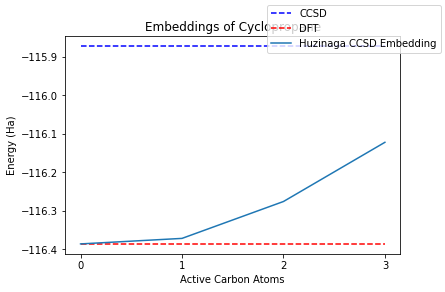

In [76]:
fig, ax = plt.subplots()
ax.hlines(whole_ccsd, min(active_atoms), max(active_atoms), colors='blue', linestyle='dashed', label='CCSD')
ax.hlines(whole_dft, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label='DFT')
ax.plot(active_atoms, energies, label='Huzinaga CCSD Embedding')
ax.set_xlabel('Active Carbon Atoms')
ax.set_ylabel('Energy (Ha)')
ax.set_xticks(active_atoms)
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

/home/mwilliams/anaconda3/envs/nbed/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


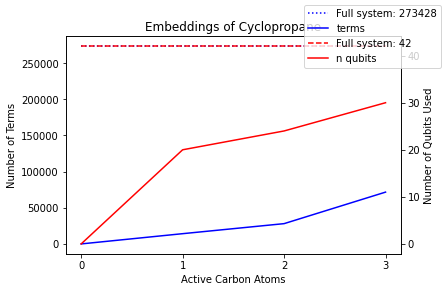

In [77]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax2.set_ylabel('Number of Qubits Used')
ax2.hlines(full_n_qubits, min(active_atoms), max(active_atoms), colors='red', linestyle='dashed', label=f'Full system: {full_n_qubits}')
ax2.plot(active_atoms, n_qubits, linestyle='solid', color='red', label='n qubits')
ax.hlines(full_terms, min(active_atoms), max(active_atoms), colors='blue', linestyle='dotted', label=f'Full system: {full_terms}')
ax.plot(active_atoms, terms, linestyle='solid', color='blue', label='terms')
ax.set_xlabel('Active Carbon Atoms')
ax.set_xticks(active_atoms)
ax.set_ylabel('Number of Terms')
ax.set_title('Embeddings of Cyclopropane')
fig.legend()
fig.show()

In [369]:
# Extract data from the results json files

data = {}
for file in Path("../results/").iterdir():
    if "spade" in file.name:
        continue
    
    with open(file, 'r') as f:
        file_data = json.load(f)

    mol_name = file_data['mol_name']
    data[mol_name] = file_data
    data[mol_name]['full'].pop('qham')

    for i in range(5):
        n_data = data[mol_name].get(str(i), False)
        if n_data:
            n_data['huz'].pop('qham')
            n_data['mu'].pop('qham')

data = {key: data[key] for key in sorted(data) if data[key]['1']['mu']['ground']}

In [377]:
import pandas as pd
df = pd.DataFrame(data).T

In [409]:
full_vals = pd.DataFrame(df['full'].to_list(), index=df['mol_name'])
one_mu = pd.DataFrame([v['mu'] for v in df['1'].to_list()], index=df['mol_name'])
one_huz = pd.DataFrame([v['huz'] for v in df['1'].to_list()], index=df['mol_name'])


In [411]:
one_mu

,terms,n_qubits,classical_energy,ground
mol_name,,,,
ammonia,864,10,-15.603924,-55.672846
carbon dioxide,156,10,-160.049547,-185.885440
diazene,1815,12,-68.424506,-109.023200
ethane,5793,16,-53.344141,-78.804733
ethene,3366,14,-52.102773,-77.549048
ethine,1079,12,-50.858880,-76.290907
methane,824,10,-14.541148,-39.988173
nitrogen,300,10,-66.893097,-107.928304
oxygen,704,10,-86.054433,-148.004523


In [397]:
mol_names = df['mol_name'].to_list()
full_vals = df['full'].to_list()
ccsd_vals = df['e_ccsdt'].to_list()

act_1 = df['1'].to_list()
act_2 = df['2'].to_list()

mu_vals = [v['mu'] for v in act_1]
huz_vals = [v['huz'] for v in act_1]

full_qubits = np.array([v['n_qubits'] for v in full_vals])
full_terms = np.array([v['terms'] for v in full_vals])

mu_qubits = np.array([v['mu']['n_qubits'] for v in act_1])
mu_terms = [v['mu']['terms'] for v in act_1 if type(v) is dict]
huz_qubits = np.array([v['huz']['n_qubits'] for v in act_1])
huz_terms = [v['huz']['terms'] for v in act_1 if type(v) is dict]

array([0.625     , 0.33333333, 0.5       , 0.5       , 0.5       ,
       0.5       , 0.55555556, 0.5       , 0.5       , 0.71428571])

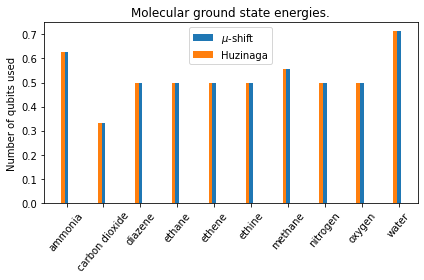

In [399]:
x = np.arange(len(mol_names))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
#rects2 = ax.bar(x + width, full_qubits, width, label='Full system.')
rects3 = ax.bar(x, mu_qubits/full_qubits, width, label='$\mu$-shift')
rects3 = ax.bar(x - width, huz_qubits/full_qubits, width, label='Huzinaga')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Number of qubits used")
ax.set_title('Molecular ground state energies.')
ax.set_xticks(x)
ax.set_xticklabels(mol_names)
ax.tick_params(axis="x", rotation=50)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects3)
# autolabel(rects2)

fig.tight_layout()

plt.show()

In [342]:
[i['terms'] for  i in df.loc[:,'full']]

[5389, 16170, 8865, 46105, 33747, 9085, 8776, 2951, 2239, 1654]

In [297]:
import matplotlib.pyplot as plt
import numpy as np

energies_full = [v['ground'] if v['ground'] is not None else 0 for v in full_vals]
energies_dft = [v['e_dft'] if v['e_dft'] is not None else 0 for v in data.values()]
energies_mu = [v['ground'] if v['ground'] is not None else 0 for v in mu_vals]
energies_huz = [v['ground'] if v['ground'] is not None else 0 for v in huz_vals]

energies_full = np.array(energies_full)
energies_dft = np.array(energies_dft)
energies_mu = np.array(energies_mu)
energies_huz = np.array(energies_huz)
energies_ccsd = np.array(ccsd_vals)

dft_diffs = [100*(dft -ccsd)/ccsd if (dft and ccsd) else 0 for dft, ccsd in zip(energies_dft, energies_ccsd)]
mu_diffs = [100*(v -ccsd)/ccsd if (v and ccsd)  else 0 for v, ccsd in zip(energies_mu, energies_ccsd)]
huz_diffs = [100*(v -ccsd)/ccsd if (v and ccsd) else 0 for v, ccsd in zip(energies_huz, energies_ccsd)]



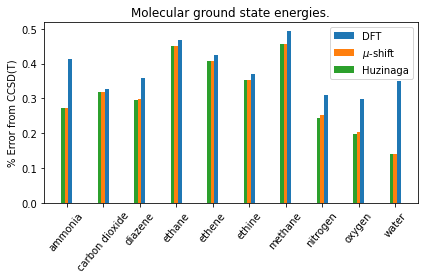

In [298]:
x = np.arange(len(mol_names))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects2 = ax.bar(x + width, dft_diffs, width, label='DFT')
rects3 = ax.bar(x, mu_diffs, width, label='$\mu$-shift')
rects3 = ax.bar(x - width, huz_diffs, width, label='Huzinaga')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Error from CCSD(T)")
ax.set_title('Molecular ground state energies.')
ax.set_xticks(x)
ax.set_xticklabels(mol_names)
ax.tick_params(axis="x", rotation=50)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects3)
# autolabel(rects2)

fig.tight_layout()

plt.show()

0.1 [0 1 2 3 4 5 6 7 8 9]


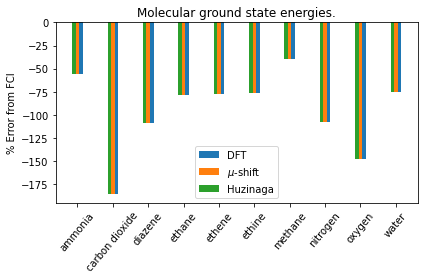

In [299]:


x = np.arange(len(mol_names))  # the label locations
width = 0.1  # the width of the bars

print(width, x)

fig, ax = plt.subplots()
rects2 = ax.bar(x + width, energies_dft, width, label='DFT')
rects3 = ax.bar(x, energies_mu, width, label='$\mu$-shift')
rects3 = ax.bar(x - width, energies_huz, width, label='Huzinaga')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("% Error from FCI")
ax.set_title('Molecular ground state energies.')
ax.set_xticks(x)
ax.set_xticklabels(mol_names)
ax.tick_params(axis="x", rotation=50)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects3)
# autolabel(rects2)

fig.tight_layout()

plt.show()

## General Params 
threshold
basis
xc functional


## Small molecules

One for SPADE
One for IBO
Molecule, active atoms(AOs), dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)


Graphs:
Bar graph of molecules energies, hamiltonian size
Cyclic molecule: terms / qubits, energy
bonus: compare molecular orbitals


## H4
One for different numbers of active atoms 1-3
Angle, dft energy, embedding (huz/mu), full_system: fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)

## Water
Bond length, dft energy, embedding (huz/mu), fci/ccsd, mu: qubits(terms), huz: qubits(terms), full:qubits(terms)